Lately I've been playing around with the [anasazi](https://trilinos.org/packages/anasazi/) library. It's basically a library that implements algorithms to solve eigenvalue problems that are all completely unaware of the underling data structures. The way this is done is by implementing the algorithms in terms of an **interface**. Basically, this interface is a contract between whoever wrote the library, and whoever is using it. It's a formal way for the library writer to say "If you give me an object that implements x, and y, this library will do Z with that object."

This idea is a bit... abstract. *And that's the whole point*. Two places where this idea is used constantly are the Python Standard Library and the C++ Standard Template Library (STL). In Python, any object that implements \__iter__ and \__next__ is automatically considered an iterable, and this opens up a ton of the standard library. In C++, similar functionality is done using iterators, the basic type that all of the STL algorithms work on. 

In python, for instance, this allows you to define a custom collection with \__iter__ and \__next__, and now you automatically get any(), all(), list() and so on, *regardless of what it is your collection does*.

This has the significant advantage that the algorithms and data structures you use become decoupled. Therefore to implement N algorithms on M data structures, you only need to implement N + M things around a common interface, rather than the N * M combinations of algorithms and data structures. It's never quite this amazing in practice, but it's close. 

## Moving Past numpy: Separating Algorithms and data structures in Linear Algebra

This is getting long winded. Assume for now that numpy is not doing what we need (say, we need memory - distributed matrices for our problem or something). Rather than rewrite an entire algorithm for another type, why not abstract away numpy in the first place? Then we simply need to write an interface between our algorithm and any data structure we want it to be able to use. 

## Case Study - The Similarity Transform

Python's duck typing actually makes this almost too easy to be true. However I prefer the explicit abstract method interface: here's the imports:

In [13]:
from abc import ABC, ABCMeta, abstractmethod
import numpy as np
np.set_printoptions(suppress=True)
from IPython.display import display

Lets write out a function for a similarity transform, 
$\mathbf{\tilde{A}} = \mathbf{S}^{-1}\mathbf{A}\mathbf{S}$, 
but let's use this idea of an abstract interface. The funny thing is, this looks remarkable like psuedo - code:

In [14]:
def SimilarityTransform(STInterface, other):
    assert isinstance(STInterface, SimilarityTransformInterface)
    return STInterface.inverse() @ other @ STInterface

Here we assumed that there's something out there called a SimilarityTransformInterface, and the thing we are being passed is an instance of that. Think for a second: what would this interface need to look like? Well, anything conforming to this interface has to implement an inverse() method as well as the @ operator, the python operator for matrix multliplication (since Python 3.5 - you're not still using python 2 right?). 

The cool thing is, you can express this idea by defining an *Abstract Base Class* with *Abstract Methods*. Basically, an abstract base class cannot be instantiated, but it can be subclassed. The rule is, any subclass must implement all methods marked as abstract by the @abstractmethod decorator. 

So let's define our abstract base class: 

In [15]:
class SimilarityTransformInterface(metaclass=ABCMeta):
    
    @abstractmethod
    def inverse(self): pass
        
    @abstractmethod
    def __matmul__(self, other): pass

    @classmethod
    def __subclasshook__(cls, C):
        """Any class that implements all abstract methods of this ABC is a subclass.
        
        This does not require that they inherit from this class!!!        
        """
        if cls is SimilarityTransformInterface:
            requirements_met = []
            for r in __class__.__abstractmethods__:
                requirements_met.append(any(r in B.__dict__ for B in C.__mro__))
            if all(requirements_met):
                return True
        return NotImplemented        

Here we've basically instructed anybody who wants to subclass this class that they must implement inverse() and \__matmul__ themselves.

But that's not all. The \__subclasshoook__ method is where it gets real funky. It basically patches python's issubclass and isinstance methods, and this function as written here basically tells python that  **any class that implements all of the abstractmethods IS A SimilarityTransformInterface**, and there's no need to inherit from it!

In [36]:
class NotOne: pass
class IsOne:
    def inverse(self): pass
    def __matmul__(self): pass
    
print(issubclass(NotOne, SimilarityTransformInterface))
print(issubclass(IsOne, SimilarityTransformInterface))

False
True


So now we've defined our interface, and we can check to make sure whatever we're being passed conforms to it. We're now officially done writing the algorithm. Now all we have to do is write a wrapper for whatever our data types are to make them conform to the interface. I did this for numpy arrays below by copying fromt their documentation:

In [16]:
class NumpyShim(np.ndarray):
    """This wraps a numpy array object into a SimiliarityTransformInterface compliant object."""

    def __new__(cls, input_array):
        obj = np.asarray(input_array).view(cls)
        return obj
    
    def __array_finalize__(self, obj):
        if obj is None: return

    def inverse(self):
        print("I just used the np.linalg.inv inverse")
        return np.linalg.inv(self)

Ignore the \__new__ and \__aray_finalize__ functions. They have to do with complications of subclassing numpy arrays. Since numpy already defines the \__matmul__ function (for using @ on numpy arrays) all I have to define is the inverse. Numpy also has an inverse function, so I can just call that function within inverse(). Right now this all probably looks like a lot more work to write a one line numpy function, but bear with me. 

Let's first make sure that our similarity transform algorithm works on numpy arrays. We can test this by diagonalizing a symmetric matrix, and seeing if we can use the eigenvectors to transform it into a diagonal matrix of eigenvalues. 

In [37]:
A = np.random.randn(4, 4)
A = A + A.T
evals, evecs = np.linalg.eigh(A)

S = NumpyShim(evecs)
M = NumpyShim(A)

print("Eigenvalues are: ", evals)

SimilarityTransform(S, M)

Eigenvalues are:  [-3.71087275 -1.94249831 -0.09555686  3.90007723]
I just used the np.linalg.inv inverse


NumpyShim([[-3.71087275, -0.        , -0.        ,  0.        ],
           [-0.        , -1.94249831, -0.        ,  0.        ],
           [ 0.        ,  0.        , -0.09555686, -0.        ],
           [ 0.        ,  0.        , -0.        ,  3.90007723]])

Wohoo! It works! But that was a lot of work for basically nothing. Here's where it can get interesting. We know that we have orthogonal eigenvectors of a hermitian matrix, and we know that the inverse of an orthogonal matrix is just it's transpose. So let's not waste our time calculating the inverse when we could just do the transpose. But we don't wanna mess with the algorithm when we know it works:

Let's do this by making a specialized OrthogonalArray class, whose inverse() method is just the transpose operation. Like so:

In [28]:
class OrthogonalArray(NumpyShim):
    """Specializes inverse function for orthogonal numpy arrays"""
    
    def __init__(self, *args, **kwargs):
        assert(np.allclose((self.T @ self - np.eye(len(self))), 0.0 )), "Must be orthogonal!"
    
    def inverse(self):
        print("I just used the orthogonal array inverse")
        return self.T

Now all we have to do is convert our eigenvectors to be an OrthogonalArray and call the similarity transform on that. Note that it uses the orthogonal array inverse function. 

In [38]:
sym = OrthogonalArray(evecs)
SimilarityTransform(sym, A)

I just used the orthogonal array inverse


OrthogonalArray([[-3.71087275, -0.        , -0.        ,  0.        ],
                 [-0.        , -1.94249831,  0.        ,  0.        ],
                 [-0.        , -0.        , -0.09555686, -0.        ],
                 [ 0.        ,  0.        , -0.        ,  3.90007723]])

Ok that's pretty neat, isn't it? We can specialize our data structures to optimize certain restrictions that we know to be true. But the underlying algorithm is unchanged. 

If you're still not convinced, imagine the following: You could use a sparse array, an out-of-memory dask array, or maybe a massively parallel Trilinos or Petsc array to do this **same algorithm** they just *need to implement the correct interface*. 


## Ok let's get real weird

Allow me to demonstrate. I'm going to use the same function to do a *symbolic* similarity transform using sympy.

In [30]:
from sympy import Matrix, init_printing, symbols
init_printing(use_unicode=True)

class SympyShim(Matrix):
    def __init__(self, mat):
        self = mat
        
    def inverse(self):
        return self.inv()

Again, sympy implements the @ operator for us already. (We could have actually required .inv() instead of .inverse() and used both numpy and sympy, but I wanted to illustrate). So we spend the 10 seconds it takes to implement our interface using sympy Matrices. 

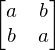

In [31]:
a, b = symbols('a b')
a = Matrix([[a, b], [b, a]])
display(a)

Let's take a look at the eigenvalues and vectors:

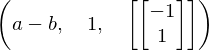

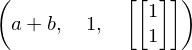

In [10]:
pair1, pair2 = a.eigenvects()
display(pair1)
display(pair2)

Sympy gives us (eigenvalue, multiplicity, eigenvector) tuples as a result, so we have our eigenvectors and values. Lets make a single matrix for the vectors:

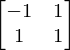

In [11]:
sympy_evecs = pair1[2][0].col_insert(1, pair2[2][0])
sympy_evecs

Now just convert to our interface type, and use our similarity transform:

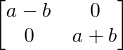

In [12]:
s = SympyShim(sympy_evecs)
SimilarityTransform(s, a)

**What the >^_!** it works!!!  Ok maybe I'm overexaggerating what's going on here but I've demonstrated the core idea here. This is an incredibly simple function that I'm implementing but the core idea is the same. **The duck typing of Python makes it an ideal language to implement abstract algorithms that are independent of the underling datatypes**. Can you do this type of thing in C++? Surely, but get your templates and 1200 character types ready. 

I also think that a lot of linear algebra algorithms are a great target for this approach. Writing a lot of the interface code is quite straightforward (it really really really looks like pseudo code) and then you just have to wrap a lot of very commonly implemented tasks anyway (inverse, dot product, etc). 

Then you can leverage a lot of linear algebra packages: numpy/scipy, theano, dask, pestc, trilinos, CUDABLAS, tensorflow, etc. with the same algorithms. 

You can also do **Matrix free computation where you never even store a matrix**. This problem happens all the time if you're dealing with very large matrices that are hundreds of thousands or millions of rows. 

Maybe we can re implement [anasazi](https://trilinos.org/packages/anasazi/) eigensolvers at the algorithm level in python. Then we can have plug-n-play Lanczos, Arnoldi, Davidson, etc algorithms.

Last thing then I'll be quiet. Imagine using this approach in conjunction with numpy as a proof of concept of your algorithm. Come production time, just write a wrapper for theano and if you do it properly you ought to be able to generate the compute graph of your entire algorithm, and let theano optimize and compile it. I really think this approach to solving problems will really shine when paired with the Python scientific stack.